In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-19 08:50:34.634717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150, size = 157):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    
    
    for label in labels:
        DIR = dir_path + label
        n = 0
        for img in tqdm(os.listdir(DIR)):
            if n != size: 
                path = os.path.join(DIR,img)
                # reading images
                img = cv2.imread(path,cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # resizing images to (150, 150, 3), 3 is the number of channels - RGB
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

                X.append(np.array(img))
                Z.append(str(label))
                
                n += 1
            
            else:
                break
            
    ## Transform labels in Z to Y from class number
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X, dtype=float)
    X=X/255.
    return X, Y

In [3]:
labels = np.array(['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy'])

labels = np.sort(labels)
print('All individuals are {}'.format(labels))

All individuals are ['Arani' 'Inti' 'Ocuri' 'Poco' 'Rattaplan' 'Romy']


# Configuration Settings

In [4]:
dir_path = '/kaggle/input/auckland-zoo-monkeys/Auckland_Zoo_Monkeys/'

imsize = 150
EPOCHS = 10
batch_size = 64
embeddingDim = 128
num_individuals = len(labels)

# Stratified 5 fold Cross Validation

In [5]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

# Closed Set

In [6]:
X_seen, Y_seen = make_dataset(labels, dir_path)

 73%|███████▎  | 157/214 [00:01<00:00, 84.56it/s]


## Exploring the closed set

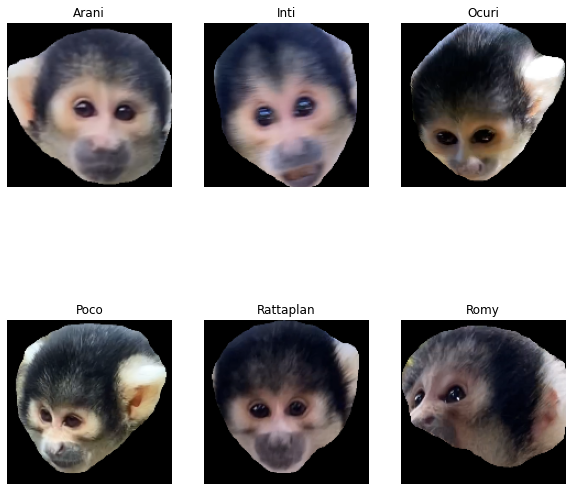

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(X_seen[Y_seen == i][0])
    plt.title(labels[i])
    plt.axis("off")

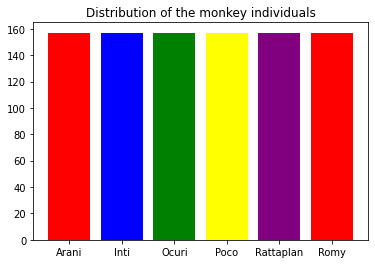

In [8]:
classes, counts = np.unique(Y_seen, return_counts = True)

plt.bar(labels[classes], counts, color=['red', 'blue', 'green', 'yellow', 'purple'])
plt.title('Distribution of the monkey individuals')
plt.show()

# Train/test set split - closed set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)

# 1. VGG16 Classification Model

In [10]:
def evaluate_vgg16(lr):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(units=num_individuals, activation='softmax')
    ])

    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

    model_vgg_16.fit(x=x_train, y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)
    
    acc = model_vgg_16.evaluate(x_val, y_val)[1]
    
    return acc

In [11]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

terms = {}
for i in lr:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        terms['{}'.format(i)].append(evaluate_vgg16(lr = i))

2021-10-19 08:50:53.420935: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 08:50:53.424280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 08:50:53.460896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 08:50:53.461534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-19 08:50:53.461584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 08:50:53.488439: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


2021-10-19 08:50:56.664494: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 08:50:56.677971: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000160000 Hz


Epoch 1/10


2021-10-19 08:50:57.296575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 08:50:58.079085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-19 08:50:58.104070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


10/10 [==============================] - 11s 194ms/step - loss: 2.0417 - acc: 0.1305
Epoch 2/10
10/10 [==============================] - 1s 62ms/step - loss: 1.7598 - acc: 0.2425
Epoch 3/10
10/10 [==============================] - 1s 61ms/step - loss: 1.6735 - acc: 0.3193
Epoch 4/10
10/10 [==============================] - 1s 61ms/step - loss: 1.5698 - acc: 0.4499
Epoch 5/10
10/10 [==============================] - 1s 63ms/step - loss: 1.4861 - acc: 0.5343
Epoch 6/10
10/10 [==============================] - 1s 66ms/step - loss: 1.4100 - acc: 0.5978
Epoch 7/10
10/10 [==============================] - 1s 65ms/step - loss: 1.3395 - acc: 0.6312
Epoch 8/10
10/10 [==============================] - 1s 63ms/step - loss: 1.2944 - acc: 0.6405
Epoch 9/10
10/10 [==============================] - 1s 62ms/step - loss: 1.2372 - acc: 0.6767
Epoch 10/10
5/5 [==============================] - 3s 300ms/step - loss: 1.2998 - acc: 0.5364
Epoch 1/10
10/10 [==============================] - 1s 61ms/step - lo

## Statistical tests - VGG16 

In [12]:
import pandas as pd
acc_vgg16 = pd.DataFrame(terms)
table_vgg16 = acc_vgg16.agg(['mean', 'std']).T
table_vgg16

,mean,std
1e-05,0.594967,0.046713
0.0001,0.798190,0.039101
0.001,0.779558,0.049357
0.01,0.782269,0.039260
0.1,0.167320,0.006931


In [13]:
! pip install autorank
from autorank import autorank, plot_stats, create_report

In [14]:
results = autorank(acc_vgg16, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
        meanrank      mean       std  ci_lower  ci_upper effect_size  \
0.0001       1.8  0.798190  0.039101   0.71768    0.8787         0.0   
0.01         2.0  0.782269  0.039260  0.701433  0.863106    0.406338   
0.001        2.2  0.779558  0.049357  0.677932  0.881185    0.418444   
1e-05        4.0  0.594967  0.046713  0.498783   0.69115    4.717806   
0.1          5.0  0.167320  0.006931  0.153049  0.181591   22.467139   

         magnitude  
0.0001  negligible  
0.01         small  
0.001        small  
1e-05        large  
0.1          large  
pvalue=0.0020825014289723187
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=True
pvals_shapiro=[0.88680499792099, 0.5046248435974121, 0.5080999732017517, 0.7331263422966003, 0.18899871408939362]
homoscedastic=False
pval_homogeneity=0.04424075989082978
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.01
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_si

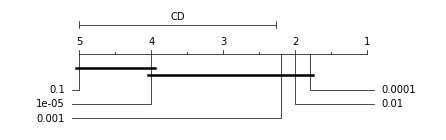

In [15]:
plot_stats(results)
plt.show()

In [16]:
create_report(results)

The statistical analysis was conducted for 5 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.189). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.044) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference 

In [17]:
acc_best_vgg16 =  acc_vgg16['0.0001']
acc_best_vgg16

0    0.735099
1    0.814570
2    0.807947
3    0.840000
4    0.793333
Name: 0.0001, dtype: float64

## Retrain VGG16 classification model on closed set

In [18]:
# choose best lr
lr = 0.0001

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
12/12 [==============================] - 3s 255ms/step - loss: 1.8199 - acc: 0.2554
Epoch 2/10
12/12 [==============================] - 1s 70ms/step - loss: 1.1889 - acc: 0.5769
Epoch 3/10
12/12 [==============================] - 1s 67ms/step - loss: 0.8747 - acc: 0.7765
Epoch 4/10
12/12 [==============================] - 1s 64ms/step - loss: 0.6786 - acc: 0.8372
Epoch 5/10
12/12 [==============================] - 1s 64ms/step - loss: 0.5728 - acc: 0.8496
Epoch 6/10
12/12 [==============================] - 1s 64ms/step - loss: 0.4372 - acc: 0.9338
Epoch 7/10
12/12 [==============================] - 1s 65ms/step - loss: 0.3670 - acc: 0.9443
Epoch 8/10
12/12 [==============================] - 1s 65ms/step - loss: 0.2862 - acc: 0.9707
Epoch 9/10
12/12 [==============================] - 1s 64ms/step - loss: 0.2515 - acc: 0.9769
Epoch 10/10
12/12 [==============================] - 1s 64ms/step - loss: 0.2042 - acc: 0.9891


In [19]:
acc_test_vgg16 = round(model_vgg_16.evaluate(X_test, Y_test)[1], 2)

print('Accuracy of VGG16 on the test set is {}'.format(acc_test_vgg16))

6/6 [==============================] - 2s 292ms/step - loss: 0.4879 - acc: 0.8360
Accuracy of VGG16 on the test set is 0.84


## Misclassified Monkeys - VGG16 - Closed set

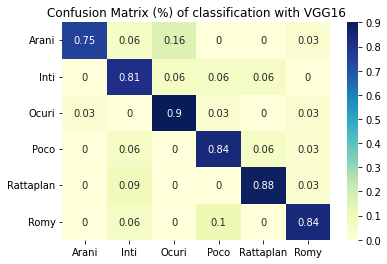

In [20]:
pred = np.argmax(model_vgg_16.predict(X_test), axis = 1)

_, counts = np.unique(Y_test, return_counts=True)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classification with VGG16')
plt.savefig('confusion_matrix_1.png')
plt.show()

# 2. Contrastive Loss

In [21]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels, num_individuals):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(num_individuals)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [22]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl.predict(x_val)
    acc = round(knn_cl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the val set with contrastive loss is {}'.format(acc))
    
    return acc

In [23]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [5, 11, 21, 31]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train, num_individuals)
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_cl_closed_set(lr = i, k = j))

Epoch 1/10
19/19 [==============================] - 6s 248ms/step - loss: 0.2468
Epoch 2/10
19/19 [==============================] - 2s 125ms/step - loss: 0.2381
Epoch 3/10
19/19 [==============================] - 2s 126ms/step - loss: 0.2304
Epoch 4/10
19/19 [==============================] - 2s 128ms/step - loss: 0.2238
Epoch 5/10
19/19 [==============================] - 2s 126ms/step - loss: 0.2140
Epoch 6/10
19/19 [==============================] - 2s 127ms/step - loss: 0.2101
Epoch 7/10
19/19 [==============================] - 2s 125ms/step - loss: 0.2027
Epoch 8/10
19/19 [==============================] - 3s 130ms/step - loss: 0.1986
Epoch 9/10
19/19 [==============================] - 2s 126ms/step - loss: 0.1935
Epoch 10/10
19/19 [==============================] - 2s 124ms/step - loss: 0.1866
Accuracy on the val set with contrastive loss is 0.68
Epoch 1/10
19/19 [==============================] - 3s 128ms/step - loss: 0.2422
Epoch 2/10
19/19 [==============================] - 2s

## Statistical tests - Contrastive Loss - closed set

In [24]:
import pandas as pd
acc_cl_closed_set = pd.DataFrame(terms)
table_cl_closed_set = acc_cl_closed_set.agg(['mean', 'std']).T
table_cl_closed_set

,mean,std
1e-05_5,0.710,0.030822
1e-05_11,0.668,0.013038
1e-05_21,0.622,0.037014
1e-05_31,0.622,0.013038
0.0001_5,0.778,0.021679
0.0001_11,0.796,0.021909
0.0001_21,0.796,0.039115
0.0001_31,0.792,0.042071
0.001_5,0.772,0.013038
0.001_11,0.766,0.040373


In [25]:
results = autorank(acc_cl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
           meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.0001_11       2.6  0.796  0.021909  0.754645  0.837355         0.0   
0.0001_21       2.6  0.796  0.039115  0.754645  0.837355         0.0   
0.0001_31       3.8  0.792  0.042071  0.750645  0.833355    0.119257   
0.0001_5        4.3  0.778  0.021679  0.736645  0.819355    0.825897   
0.001_5         4.9  0.772  0.013038  0.730645  0.813355     1.33128   
0.001_11        5.3  0.766  0.040373  0.724645  0.807355    0.923624   
0.001_21        6.2  0.762  0.021679  0.720645  0.803355    1.560027   
0.001_31        6.7  0.750  0.052440  0.708645  0.791355    1.144647   
1e-05_5         9.4  0.710  0.030822  0.668645  0.751355    3.216218   
0.01_11        11.6  0.670  0.046368  0.628645  0.711355    3.474623   
0.01_21        11.8  0.666  0.029665  0.624645  0.707355    4.985272   
1e-05_11       11.9  0.668  0.013038  0.626645  0.709355    7.100163   
0.01_5         13.2  0.662  0.061806  0.62064

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


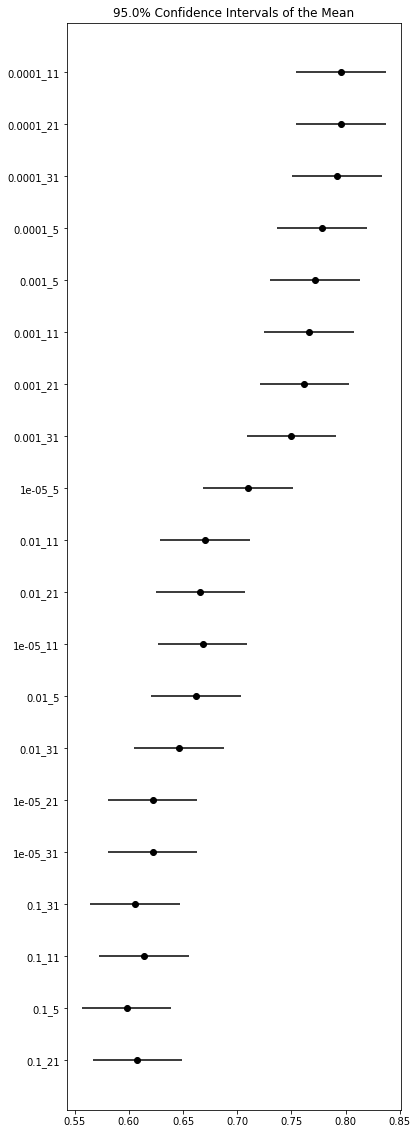

In [26]:
plot_stats(results)
plt.show()

In [27]:
create_report(results)

The statistical analysis was conducted for 20 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.077). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.187) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

In [28]:
acc_best_cl_closed_set =  acc_cl_closed_set['0.0001_11']
acc_best_cl_closed_set

0    0.76
1    0.80
2    0.79
3    0.79
4    0.75
Name: 0.0001_5, dtype: float64

## Retrain Contrastive Loss on closed set

Epoch 1/10
24/24 [==============================] - 7s 258ms/step - loss: 0.2442
Epoch 2/10
24/24 [==============================] - 3s 125ms/step - loss: 0.1955
Epoch 3/10
24/24 [==============================] - 3s 124ms/step - loss: 0.1599
Epoch 4/10
24/24 [==============================] - 3s 124ms/step - loss: 0.1363
Epoch 5/10
24/24 [==============================] - 3s 125ms/step - loss: 0.1197
Epoch 6/10
24/24 [==============================] - 3s 126ms/step - loss: 0.1013
Epoch 7/10
24/24 [==============================] - 3s 123ms/step - loss: 0.0878
Epoch 8/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0745
Epoch 9/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0692
Epoch 10/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0600


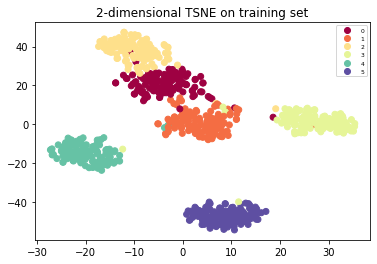

Accuracy of Constractive Loss on test set is 0.79


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 3}
plot.rcParams.update(params)


# choose best lr and k
lr = 0.0001
k = 11

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train, num_individuals)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float)

tsne_cl = TSNE(n_components=2, random_state=1).fit_transform(embedding_train_cl)

scatter = plt.scatter(tsne_cl[:, 0], tsne_cl[:, 1], c=Y_train, cmap=plt.cm.Spectral)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, range(len(labels)))
plt.title('2-dimensional TSNE on training set')
plt.show()

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
acc_cl_test_closed_set = round(knn_cl.score(x_test_embedding, Y_test), 2)
pred = knn_cl.predict(x_test_embedding)

print('Accuracy of Constractive Loss on test set is {}'.format(round(acc_cl_test_closed_set, 2)))

## Misclassified Monkeys - Closed set (Contrastive Loss)

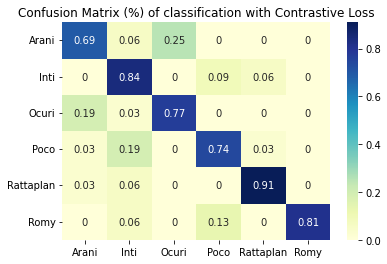

In [30]:
_, counts = np.unique(Y_test, return_counts=True)

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classification with Contrastive Loss')
plt.savefig('confusion_matrix_2.png')
plt.show()

# 3. Triplet Loss

In [31]:
def evaluate_tl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl.predict(x_val)
    acc = round(knn_tl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the the val set with Tripolet Loss is {}'.format(acc))
    
    return acc

In [32]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [5, 11, 21, 31]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []
        
for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_tl_closed_set(lr = i, k = j))

Epoch 1/10
10/10 [==============================] - 2s 61ms/step - loss: 0.9940
Epoch 2/10
10/10 [==============================] - 1s 61ms/step - loss: 0.9935
Epoch 3/10
10/10 [==============================] - 1s 61ms/step - loss: 0.9921
Epoch 4/10
10/10 [==============================] - 1s 61ms/step - loss: 0.9914
Epoch 5/10
10/10 [==============================] - 1s 62ms/step - loss: 0.9903
Epoch 6/10
10/10 [==============================] - 1s 62ms/step - loss: 0.9890
Epoch 7/10
10/10 [==============================] - 1s 61ms/step - loss: 0.9860
Epoch 8/10
10/10 [==============================] - 1s 61ms/step - loss: 0.9837
Epoch 9/10
10/10 [==============================] - 1s 63ms/step - loss: 0.9809
Epoch 10/10
10/10 [==============================] - 1s 62ms/step - loss: 0.9712
Accuracy on the the val set with Tripolet Loss is 0.74
Epoch 1/10
10/10 [==============================] - 1s 62ms/step - loss: 0.9947
Epoch 2/10
10/10 [==============================] - 1s 62ms/step

## Statistical tests - Triplet loss - Closed Set

In [33]:
import pandas as pd
acc_tl_closed_set = pd.DataFrame(terms)
table_tl_closed_set = acc_tl_closed_set.agg(['mean', 'std']).T
table_tl_closed_set

,mean,std
1e-05_5,0.742,0.008367
1e-05_11,0.706,0.021909
1e-05_21,0.660,0.018708
1e-05_31,0.674,0.020736
0.0001_5,0.832,0.026833
0.0001_11,0.836,0.011402
0.0001_21,0.826,0.015166
0.0001_31,0.836,0.018166
0.001_5,0.864,0.027019
0.001_11,0.836,0.026077


In [34]:
results = autorank(acc_tl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
           meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.001_5         2.1  0.864  0.027019   0.78234   0.94566         0.0   
0.001_31        2.8  0.862  0.022804  0.793079  0.930921        0.08   
0.001_21        3.4  0.856  0.024083  0.783211  0.928789    0.312586   
0.0001_31       4.8  0.836  0.018166  0.781096  0.890904    1.216242   
0.001_11        5.3  0.836  0.026077  0.757186  0.914814    1.054541   
0.0001_11       5.3  0.836  0.011402   0.80154   0.87046     1.35028   
0.0001_5        6.0  0.832  0.026833  0.750901  0.913099     1.18845   
0.0001_21       6.3  0.826  0.015166  0.780163  0.871837    1.734455   
0.01_31        10.8  0.758  0.041473  0.632653  0.883347    3.028571   
0.01_11        10.8  0.766  0.018166  0.711096  0.820904    4.256848   
0.01_5         11.3  0.752  0.054955  0.585906  0.918094    2.586529   
0.01_21        12.1  0.746  0.036469  0.635776  0.856224    3.676744   
1e-05_5        12.7  0.742  0.008367  0.71671

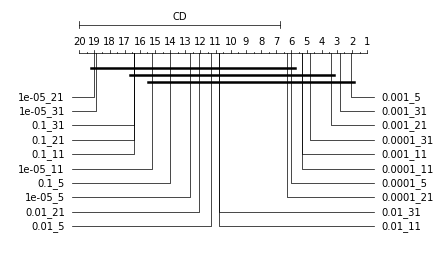

In [35]:
plot_stats(results)
plt.show()

In [36]:
create_report(results)

The statistical analysis was conducted for 20 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.111). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.003) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference

In [37]:
acc_best_tl_closed_set =  acc_tl_closed_set['0.001_5']
acc_best_tl_closed_set

0    0.85
1    0.88
2    0.83
3    0.86
4    0.90
Name: 0.001_5, dtype: float64

## Retrain Triplet Loss on closed set

Epoch 1/10
12/12 [==============================] - 1s 65ms/step - loss: 0.9836
Epoch 2/10
12/12 [==============================] - 1s 65ms/step - loss: 0.9241
Epoch 3/10
12/12 [==============================] - 1s 64ms/step - loss: 0.9208
Epoch 4/10
12/12 [==============================] - 1s 69ms/step - loss: 0.8434
Epoch 5/10
12/12 [==============================] - 1s 64ms/step - loss: 0.7126
Epoch 6/10
12/12 [==============================] - 1s 65ms/step - loss: 0.6374
Epoch 7/10
12/12 [==============================] - 1s 64ms/step - loss: 0.5222
Epoch 8/10
12/12 [==============================] - 1s 64ms/step - loss: 0.5164
Epoch 9/10
12/12 [==============================] - 1s 64ms/step - loss: 0.4010
Epoch 10/10
12/12 [==============================] - 1s 64ms/step - loss: 0.3008


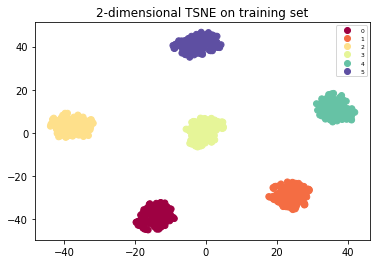

Accuracy of Triplet Loss on the test set is 0.9


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import pylab as plot

# choose best lr and k
lr = 0.001
k = 5

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

tsne_tl = TSNE(n_components=2, random_state=1).fit_transform(embedding_train_tl)

scatter = plt.scatter(tsne_tl[:, 0], tsne_tl[:, 1], c=Y_train, cmap=plt.cm.Spectral)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, range(len(labels)))
plt.title('2-dimensional TSNE on training set')
plt.savefig('T-SNE_Triplet Loss.png')
plt.show()

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
acc_tl_test_closed_set = round(knn_tl.score(x_test_embedding, Y_test), 2)
pred = knn_tl.predict(x_test_embedding)

print('Accuracy of Triplet Loss on the test set is {}'.format(round(acc_tl_test_closed_set, 2)))

## Misclassified Monkeys - Closed set (Triplet Loss)

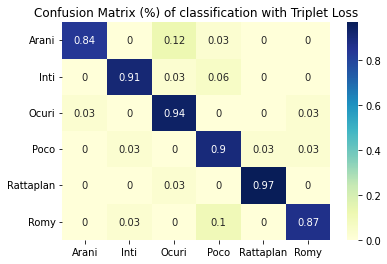

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

_, counts = np.unique(Y_test, return_counts=True)

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classification with Triplet Loss')
plt.savefig('confusion_matrix_3.png')
plt.show()

# Summary on Closed Set

In [54]:
# After tuning hps (lr and k), the best accuracy on val set.
best_vgg16 = table_vgg16.loc['0.0001']
best_cl = table_cl_closed_set.loc['0.0001_11']
best_tl = table_tl_closed_set.loc['0.001_5']

pd.DataFrame({'VGG16_(LR = 0.0001)': best_vgg16,
              'Contrastive_Loss(LR = 0.0001, k = 11)': best_cl, 
              'Triplet_Loss(LR = 0.001, k = 5)': best_tl
             })

,VGG16_(LR = 0.0001),"Contrastive_Loss(LR = 0.0001, k = 11)","Triplet_Loss(LR = 0.001, k = 5)"
mean,0.798190,0.796000,0.864000
std,0.039101,0.021909,0.027019


In [49]:
# Accuracy on test set

pd.DataFrame([acc_test_vgg16, acc_cl_test_closed_set, acc_tl_test_closed_set], index = ['VGG16', 'Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,VGG16,Contrastive_Loss,Triplet_Loss
Accuracy,0.84,0.79,0.9


# Statistical tests - Overall

## Close Set

In [50]:
acc_closed_set = pd.DataFrame({'VGG16': acc_best_vgg16, 'Contrastive Loss': acc_best_cl_closed_set, 'Triplet Loss': acc_best_tl_closed_set})

In [51]:
results = autorank(acc_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
                  meanrank     mean       std  ci_lower  ci_upper effect_size  \
Triplet Loss           1.0  0.86400  0.027019  0.838568  0.889432         0.0   
VGG16                  2.2  0.79819  0.039101  0.772758  0.823622    1.958212   
Contrastive Loss       2.8  0.77800  0.021679  0.752568  0.803432    3.510935   

                   magnitude  
Triplet Loss      negligible  
VGG16                  large  
Contrastive Loss       large  
pvalue=0.0027905519546948315
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.5046248435974121, 0.27172717452049255, 0.9796154499053955]
homoscedastic=True
pval_homogeneity=0.5221107355838377
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


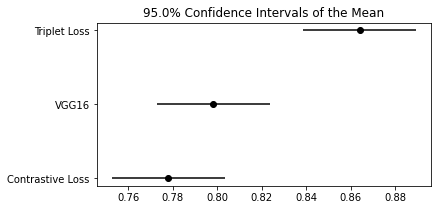

In [52]:
plot_stats(results)
plt.savefig('model_comparsion.png')
plt.show()

In [53]:
create_report(results)

The statistical analysis was conducted for 3 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.272). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.522) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confide